In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
import xgboost as xgb


def instantiate_XGBoost_model (X_train, y_train):
    param_grid = {
        "max_depth": [3, 5, 7],
        #"learning_rate": [0.1, 0.2],
        "gamma": [0.25, 1],
        #"reg_lambda": [0, 1, 10],
        "scale_pos_weight": [1, 3, 5],
        #"subsample": [0.8],
        "colsample_bytree": [0.5, 0.9] }

    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
import xgboost as xgb

def create_final_cl(X_over, y_over, X_test, y_test, colsample_bytree, gamma, max_depth, scale_pos_weight):

    # parametrizando o modelo final
    final_cl = xgb.XGBClassifier(colsample_bytree = colsample_bytree, gamma = gamma, max_depth = max_depth, scale_pos_weight = scale_pos_weight)
    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    return preds, final_cl

#### Criação de funções para plotagem de métricas:

In [10]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl):
    # plot feature importance
    plt.figure(figsize=(14,14))
    plot_importance(final_cl)
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):
    for i in range (0,838,30):
    
        #treino!
        data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
        data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
        data_fim = data_inicio + pd.Timedelta(days = d)
        
        treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
        X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
        y_train = treino['death']

        #teste!
        teste = df[(df['data_notificacao'] >= data_fim_treino) & (df['data_notificacao'] <= data_fim )]
        X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
        y_test = teste['death']

        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(X_train, y_train)

        print('Início do período: ', data_inicio)
        print('Final do período: ', data_fim)

        ####################################################
        #              APLICANDO O MODELO                  #
        ####################################################

        list_random_states = [42]
        #list_random_states = [0,12,42,50,54,68,79,81,92,112]

        mean_test_scores = []
        std_test_scores = []
        best_scores = []
        best_params = []

        for random_state in list_random_states:

            mean_test_score, std_test_score, best_score, best_param = instantiate_XGBoost_model(X_over, y_over)

            mean_test_scores.append(mean_test_score)
            std_test_scores.append(std_test_score)
            best_scores.append(best_score)
            best_params.append(best_param)

        idx = best_scores.index(max(best_scores))
        best_param = best_params[idx]
        
        preds, final_cl = create_final_cl(X_over, y_over, X_test, y_test, best_param['colsample_bytree'], best_param['gamma'], best_param['max_depth'], best_param['scale_pos_weight'])
        
        plot_conf_matrix (X_test, y_test, preds, final_cl)

        plot_roc_curve(y_test, preds)

        plot_feature_importance(final_cl)


## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_20536\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


SYMPTOM_COUGH  SYMPTOM_COLD  SYMPTOM_AIR_INSUFFICIENCY  SYMPTOM_FEVER  \
0                  0             0                          0              1   
1                  0             0                          0              1   
2                  1             0                          1              1   
3                  1             0                          1              1   
4                  1             0                          1              1   
...              ...           ...                        ...            ...   
36430              1             0                          1              1   
36431              1             0                          1              0   
36432              1             0                          1              0   
36433              1             0                          1              0   
36434              1             0                          1              0   

       SYMPTOM_LOW_OXYGEN_SATURATION  SYMPTOM_BREATHING_CONDITION  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
36430                              0                            0   
36431                              0                            0   
36432                              0                            0   
36433                              0                            0   
36434                              0                            0   

       SYMPTOM_TORACIC_APERTURE  SYMPTOM_THROAT_CONDITION  SYMPTOM_HEADACHE  \
0                             0                         1                 0   
1                             0                         1                 0   
2                             0                         1                 0   
3                             0                         1                 1   
4                             0                         0                 1   
...                         ...                       ...               ...   
36430                         0                         0                 0   
36431                         0                         0                 0   
36432                         0                         0                 0   
36433                         0                         0                 0   
36434                         0                         0                 0   

       SYMPTOM_BODY_PAIN  ...  DISEASE_IMMUNOSUPPRESSION  DISEASE_TABAGIST  \
0                      0  ...                          0                 0   
1                      0  ...                          0                 0   
2                      0  ...                          0                 0   
3                      0  ...                          0                 0   
4                      0  ...                          0                 0   
...                  ...  ...                        ...               ...   
36430                  0  ...                          0                 0   
36431                  0  ...                          0                 0   
36432                  0  ...                          0                 0   
36433                  0  ...                          0                 0   
36434                  0  ...                          0                 0   

       DISEASE_ETILISM  DISEASE_LIVER  DISEASE_NEUROLOGIC  death     idade  \
0                    0              0                   0      0  0.356522   
1                    0              0                   0      0  0.278261   
2                    0              0                   0      0  0.217391   
3                  

### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.9585387482258811
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.7445785826067516
########################################
"""Métricas f1_score:"""
f1:  0.5650104702075005
Macro:  0.6921104253877918
Micro:  0.7445785826067517
weighted:  0.7611018609294298
########################################
"""Métricas precision_score:"""
Precision:  0.4625935162094763
Macro:  0.6824121293142188
Micro:  0.7445785826067516
weighted:  0.8017324048828114


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


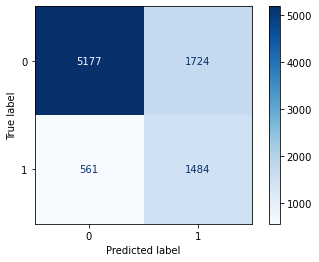

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      6901
           1       0.46      0.73      0.57      2045

    accuracy                           0.74      8946
   macro avg       0.68      0.74      0.69      8946
weighted avg       0.80      0.74      0.76      8946

roc_auc_score:  0.7379267524036239


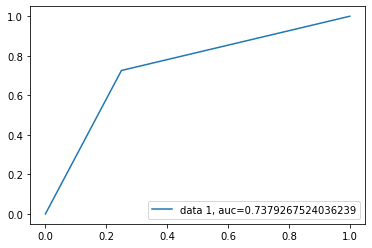

<Figure size 720x720 with 0 Axes>

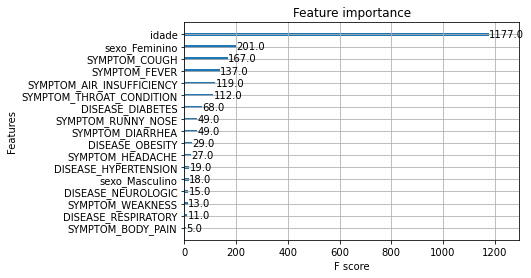

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.935083065408282
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5948954135482633
########################################
"""Métricas f1_score:"""
f1:  0.5383774327574896
Macro:  0.5887305183961837
Micro:  0.5948954135482633
weighted:  0.612336848892313
########################################
"""Métricas precision_score:"""
Precision:  0.38601442458450924
Macro:  0.6551733843990796
Micro:  0.5948954135482633
weighted:  0.7813594022127419


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


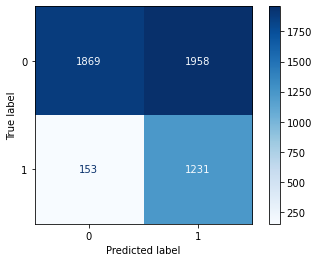

              precision    recall  f1-score   support

           0       0.92      0.49      0.64      3827
           1       0.39      0.89      0.54      1384

    accuracy                           0.59      5211
   macro avg       0.66      0.69      0.59      5211
weighted avg       0.78      0.59      0.61      5211

roc_auc_score:  0.6889114800376395


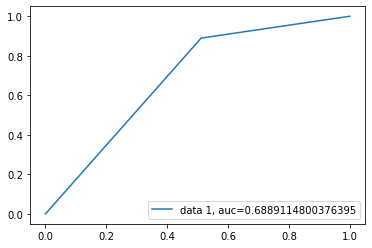

<Figure size 720x720 with 0 Axes>

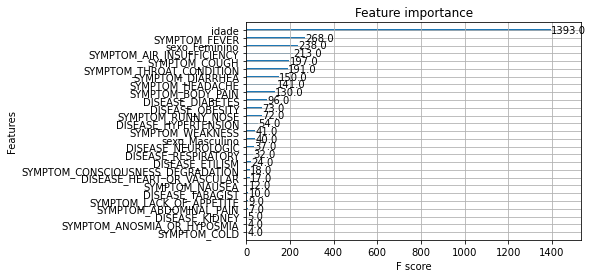

Início do período:  2020-04-26 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.8710642403325679
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.565533053114253
########################################
"""Métricas f1_score:"""
f1:  0.46644767714687935
Macro:  0.5500140416027661
Micro:  0.565533053114253
weighted:  0.5974971076883235
########################################
"""Métricas precision_score:"""
Precision:  0.3173690932311622
Macro:  0.6263344038943632
Micro:  0.565533053114253
weighted:  0.8018909254672252


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


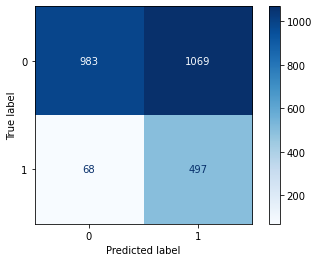

              precision    recall  f1-score   support

           0       0.94      0.48      0.63      2052
           1       0.32      0.88      0.47       565

    accuracy                           0.57      2617
   macro avg       0.63      0.68      0.55      2617
weighted avg       0.80      0.57      0.60      2617

roc_auc_score:  0.6793454260035536


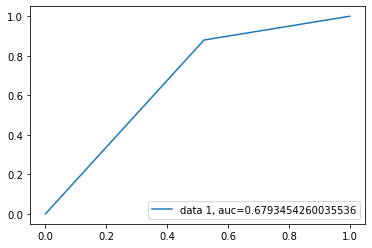

<Figure size 720x720 with 0 Axes>

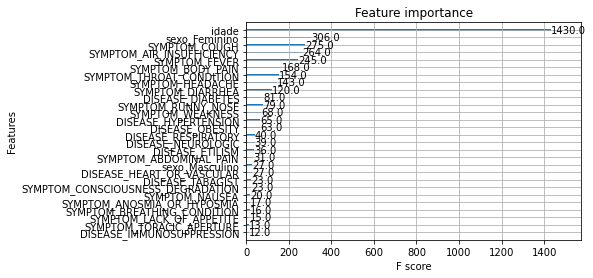

Início do período:  2020-05-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8654790593448191
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6181984453589392
########################################
"""Métricas f1_score:"""
f1:  0.4466534128561961
Macro:  0.5776024481383948
Micro:  0.6181984453589392
weighted:  0.658614814273198
########################################
"""Métricas precision_score:"""
Precision:  0.3086080586080586
Macro:  0.6177743489387325
Micro:  0.6181984453589392
weighted:  0.8090418344519478


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


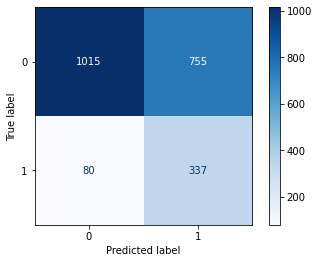

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1770
           1       0.31      0.81      0.45       417

    accuracy                           0.62      2187
   macro avg       0.62      0.69      0.58      2187
weighted avg       0.81      0.62      0.66      2187

roc_auc_score:  0.6907999024509206


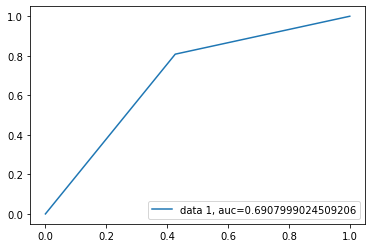

<Figure size 720x720 with 0 Axes>

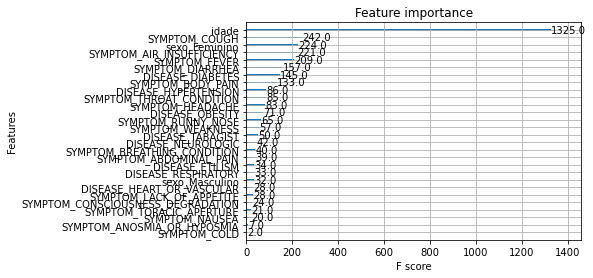

Início do período:  2020-06-25 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.921846899745308
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.647972972972973
########################################
"""Métricas f1_score:"""
f1:  0.42935377875136915
Macro:  0.5874174853698223
Micro:  0.647972972972973
weighted:  0.6867413010152016
########################################
"""Métricas precision_score:"""
Precision:  0.3072100313479624
Macro:  0.6066929016597294
Micro:  0.647972972972973
weighted:  0.7948814620583399


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


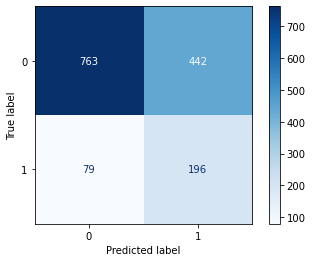

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      1205
           1       0.31      0.71      0.43       275

    accuracy                           0.65      1480
   macro avg       0.61      0.67      0.59      1480
weighted avg       0.79      0.65      0.69      1480

roc_auc_score:  0.6729611467370804


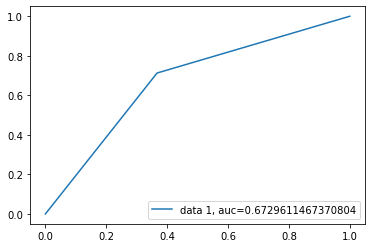

<Figure size 720x720 with 0 Axes>

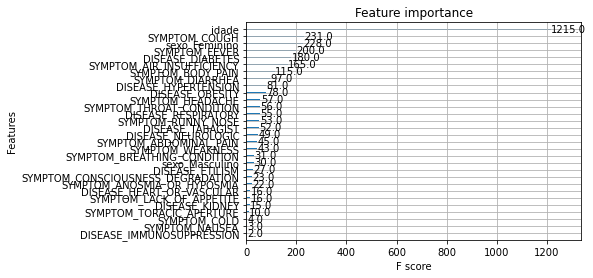

Início do período:  2020-07-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.938619708513371
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.671415004748338
########################################
"""Métricas f1_score:"""
f1:  0.45597484276729555
Macro:  0.6103003465537158
Micro:  0.671415004748338
weighted:  0.6913468836799176
########################################
"""Métricas precision_score:"""
Precision:  0.3756476683937824
Macro:  0.6091131895192301
Micro:  0.671415004748338
weighted:  0.7317213881729552


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


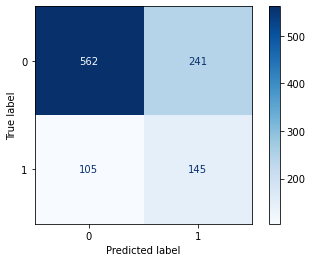

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       803
           1       0.38      0.58      0.46       250

    accuracy                           0.67      1053
   macro avg       0.61      0.64      0.61      1053
weighted avg       0.73      0.67      0.69      1053

roc_auc_score:  0.6399377334993773


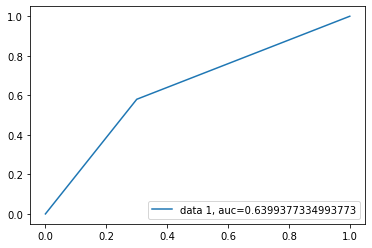

<Figure size 720x720 with 0 Axes>

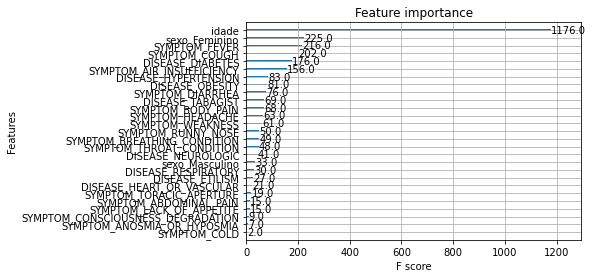

Início do período:  2020-08-24 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.932390131278692
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6639928698752228
########################################
"""Métricas f1_score:"""
f1:  0.4512372634643377
Macro:  0.6045524788741083
Micro:  0.6639928698752228
weighted:  0.6695952975327991
########################################
"""Métricas precision_score:"""
Precision:  0.4258241758241758
Macro:  0.6020941459595813
Micro:  0.6639928698752228
weighted:  0.6768753454109655


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


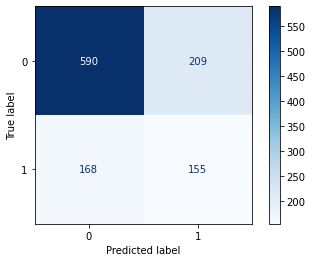

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       799
           1       0.43      0.48      0.45       323

    accuracy                           0.66      1122
   macro avg       0.60      0.61      0.60      1122
weighted avg       0.68      0.66      0.67      1122

roc_auc_score:  0.6091495948883474


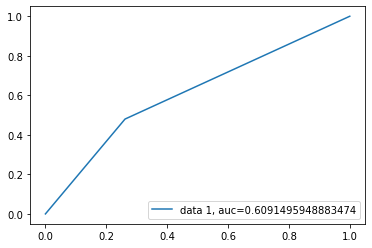

<Figure size 720x720 with 0 Axes>

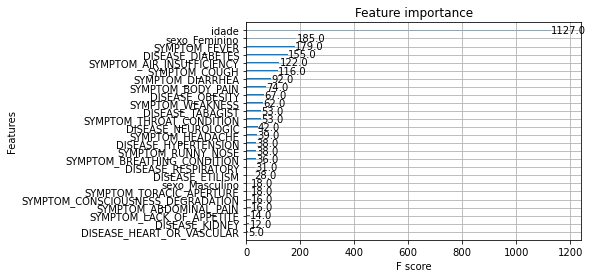

Início do período:  2020-09-23 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.8998366956593596
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.656060606060606
########################################
"""Métricas f1_score:"""
f1:  0.5319587628865979
Macro:  0.6300512377307241
Micro:  0.656060606060606
weighted:  0.6624514794216628
########################################
"""Métricas precision_score:"""
Precision:  0.48863636363636365
Macro:  0.6281565656565656
Micro:  0.656060606060606
weighted:  0.6742405111723293


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


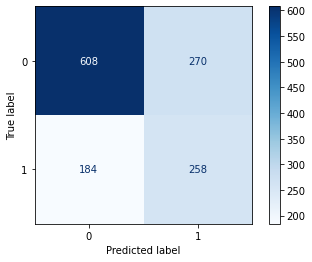

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       878
           1       0.49      0.58      0.53       442

    accuracy                           0.66      1320
   macro avg       0.63      0.64      0.63      1320
weighted avg       0.67      0.66      0.66      1320

roc_auc_score:  0.6380966614786795


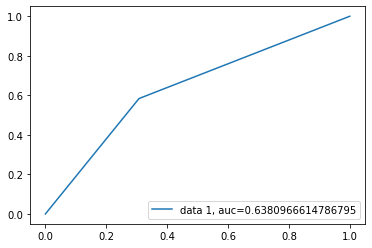

<Figure size 720x720 with 0 Axes>

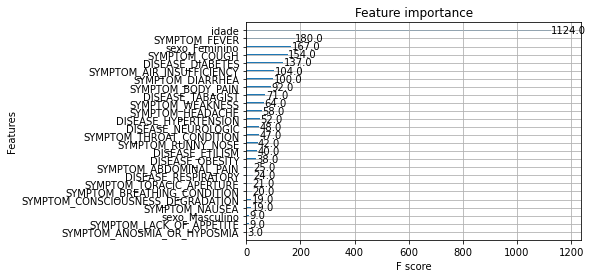

Início do período:  2020-10-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.9012734975647063
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6330213903743316
########################################
"""Métricas f1_score:"""
f1:  0.5700861393891934
Macro:  0.6249847606566958
Micro:  0.6330213903743316
weighted:  0.6419387466363657
########################################
"""Métricas precision_score:"""
Precision:  0.4789473684210526
Macro:  0.635533466819222
Micro:  0.6330213903743316
weighted:  0.6838909383833626


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


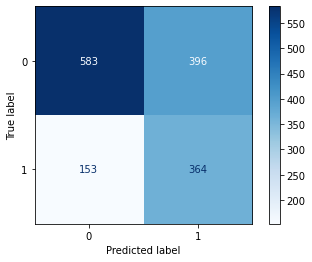

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       979
           1       0.48      0.70      0.57       517

    accuracy                           0.63      1496
   macro avg       0.64      0.65      0.62      1496
weighted avg       0.68      0.63      0.64      1496

roc_auc_score:  0.6497837567643926


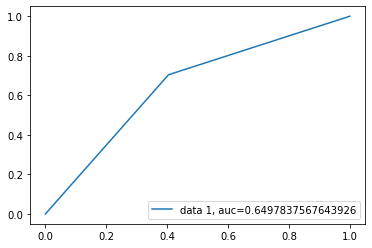

<Figure size 720x720 with 0 Axes>

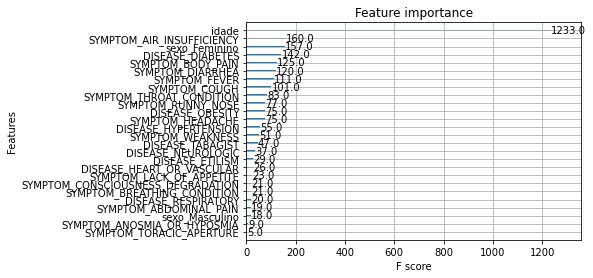

Início do período:  2020-11-22 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8687245998579168
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6472579553148273
########################################
"""Métricas f1_score:"""
f1:  0.5835331734612311
Macro:  0.638801231475184
Micro:  0.6472579553148273
weighted:  0.6570243487756545
########################################
"""Métricas precision_score:"""
Precision:  0.4828042328042328
Macro:  0.6512495505213951
Micro:  0.6472579553148273
weighted:  0.7067897466813532


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


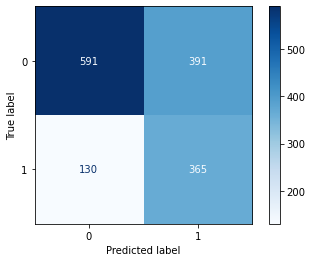

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       982
           1       0.48      0.74      0.58       495

    accuracy                           0.65      1477
   macro avg       0.65      0.67      0.64      1477
weighted avg       0.71      0.65      0.66      1477

roc_auc_score:  0.6696033656318789


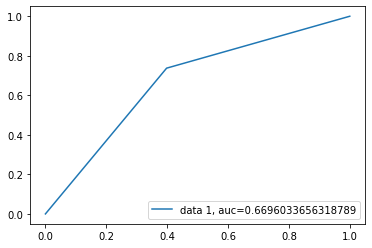

<Figure size 720x720 with 0 Axes>

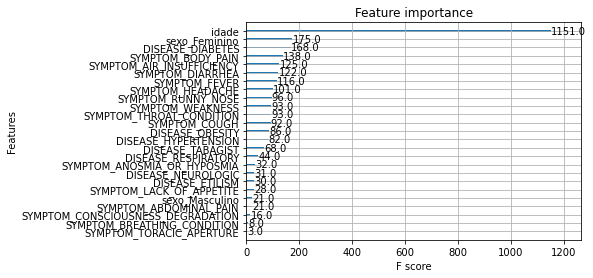

Início do período:  2020-12-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8432997016773612
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6503868471953579
########################################
"""Métricas f1_score:"""
f1:  0.5719360568383659
Macro:  0.6382361117865716
Micro:  0.6503868471953579
weighted:  0.6615116629917928
########################################
"""Métricas precision_score:"""
Precision:  0.47445972495088407
Macro:  0.6477060529516325
Micro:  0.6503868471953579
weighted:  0.7085265723561506


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


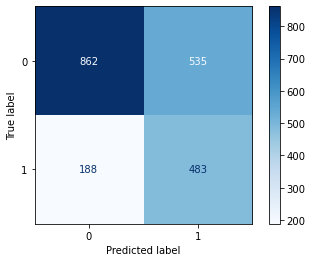

              precision    recall  f1-score   support

           0       0.82      0.62      0.70      1397
           1       0.47      0.72      0.57       671

    accuracy                           0.65      2068
   macro avg       0.65      0.67      0.64      2068
weighted avg       0.71      0.65      0.66      2068

roc_auc_score:  0.6684288346221998


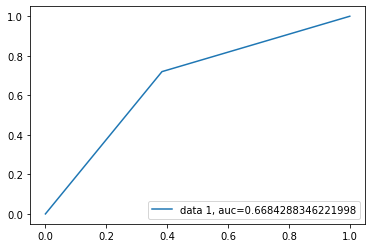

<Figure size 720x720 with 0 Axes>

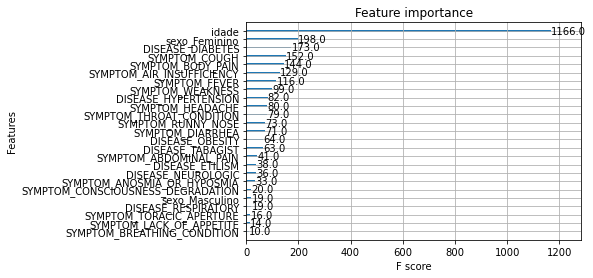

Início do período:  2021-01-21 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8512044071217003
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6629667003027245
########################################
"""Métricas f1_score:"""
f1:  0.5574204946996466
Macro:  0.6426428926512899
Micro:  0.6629667003027245
weighted:  0.6724836313891508
########################################
"""Métricas precision_score:"""
Precision:  0.4861325115562404
Macro:  0.6430662557781202
Micro:  0.6629667003027245
weighted:  0.6980168201020277


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


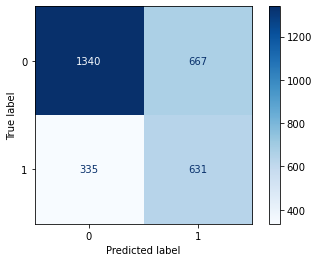

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2007
           1       0.49      0.65      0.56       966

    accuracy                           0.66      2973
   macro avg       0.64      0.66      0.64      2973
weighted avg       0.70      0.66      0.67      2973

roc_auc_score:  0.6604361443023951


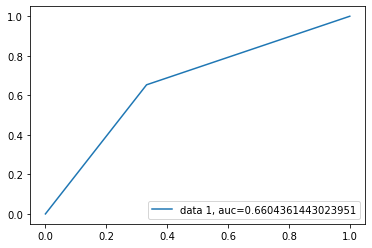

<Figure size 720x720 with 0 Axes>

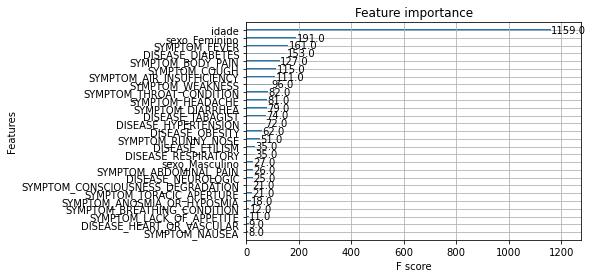

Início do período:  2021-02-20 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8568618852288455
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.594585213467546
########################################
"""Métricas f1_score:"""
f1:  0.5469356089992241
Macro:  0.5900507190724764
Micro:  0.594585213467546
weighted:  0.6058092094949459
########################################
"""Métricas precision_score:"""
Precision:  0.42367788461538464
Macro:  0.6259720565229758
Micro:  0.594585213467546
weighted:  0.6999101901636192


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


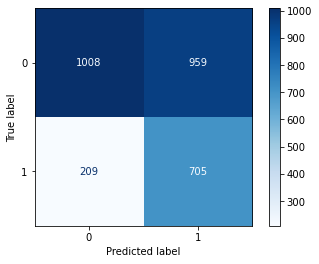

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      1967
           1       0.42      0.77      0.55       914

    accuracy                           0.59      2881
   macro avg       0.63      0.64      0.59      2881
weighted avg       0.70      0.59      0.61      2881

roc_auc_score:  0.6418951540683866


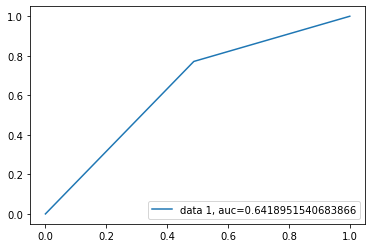

<Figure size 720x720 with 0 Axes>

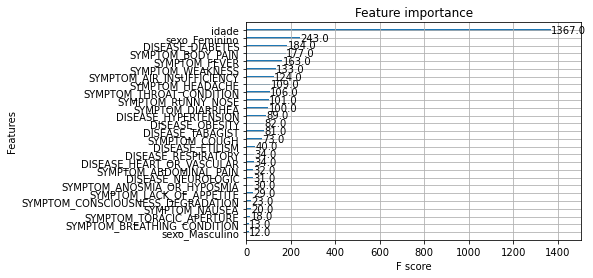

Início do período:  2021-03-22 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8508285225355268
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5714812085482682
########################################
"""Métricas f1_score:"""
f1:  0.5139991642290013
Macro:  0.5654015590502502
Micro:  0.5714812085482682
weighted:  0.5872579936942153
########################################
"""Métricas precision_score:"""
Precision:  0.38127712337259767
Macro:  0.615706681577307
Micro:  0.5714812085482682
weighted:  0.7153867516466639


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


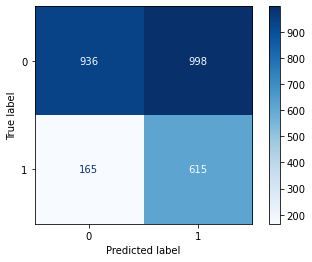

              precision    recall  f1-score   support

           0       0.85      0.48      0.62      1934
           1       0.38      0.79      0.51       780

    accuracy                           0.57      2714
   macro avg       0.62      0.64      0.57      2714
weighted avg       0.72      0.57      0.59      2714

roc_auc_score:  0.6362162914644818


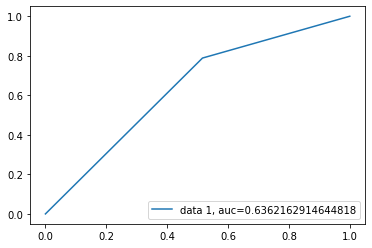

<Figure size 720x720 with 0 Axes>

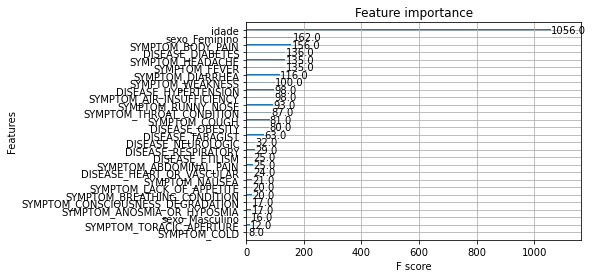

Início do período:  2021-04-21 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8758345263497734
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5687179487179487
########################################
"""Métricas f1_score:"""
f1:  0.5067448680351906
Macro:  0.5618006800312627
Micro:  0.5687179487179487
weighted:  0.5853476273157366
########################################
"""Métricas precision_score:"""
Precision:  0.37663469921534437
Macro:  0.6098615588231143
Micro:  0.5687179487179487
weighted:  0.7096108926245912


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


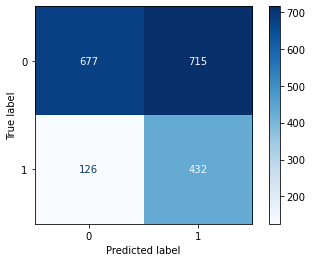

              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1392
           1       0.38      0.77      0.51       558

    accuracy                           0.57      1950
   macro avg       0.61      0.63      0.56      1950
weighted avg       0.71      0.57      0.59      1950

roc_auc_score:  0.6302720615498701


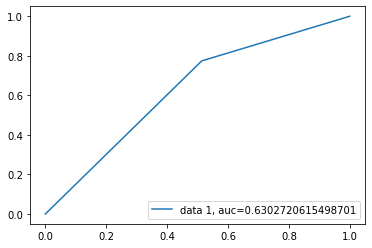

<Figure size 720x720 with 0 Axes>

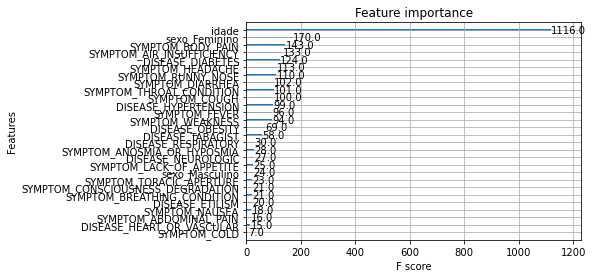

Início do período:  2021-05-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.8880442130881556
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6256323777403036
########################################
"""Métricas f1_score:"""
f1:  0.5763358778625953
Macro:  0.6204942229192131
Micro:  0.6256323777403036
weighted:  0.6346427651801868
########################################
"""Métricas precision_score:"""
Precision:  0.4682170542635659
Macro:  0.6407628709395463
Micro:  0.6256323777403036
weighted:  0.696047365321395


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


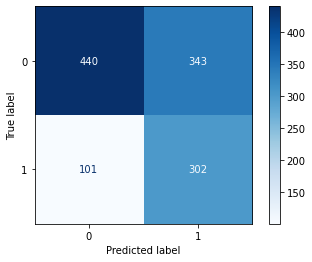

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       783
           1       0.47      0.75      0.58       403

    accuracy                           0.63      1186
   macro avg       0.64      0.66      0.62      1186
weighted avg       0.70      0.63      0.63      1186

roc_auc_score:  0.6556604521009415


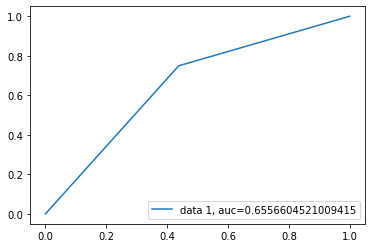

<Figure size 720x720 with 0 Axes>

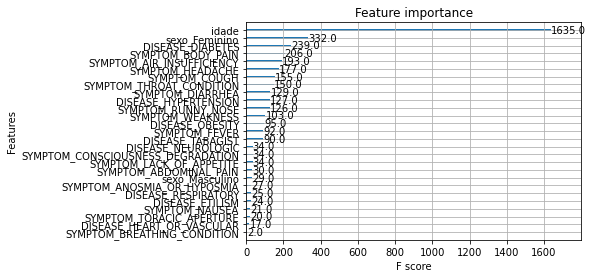

Início do período:  2021-06-20 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8769283696724124
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5992736077481841
########################################
"""Métricas f1_score:"""
f1:  0.5237410071942447
Macro:  0.5889342444539666
Micro:  0.5992736077481841
weighted:  0.6148221159081904
########################################
"""Métricas precision_score:"""
Precision:  0.4080717488789238
Macro:  0.6158779797026198
Micro:  0.5992736077481841
weighted:  0.6983966766883005


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


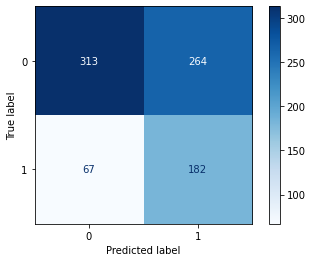

              precision    recall  f1-score   support

           0       0.82      0.54      0.65       577
           1       0.41      0.73      0.52       249

    accuracy                           0.60       826
   macro avg       0.62      0.64      0.59       826
weighted avg       0.70      0.60      0.61       826

roc_auc_score:  0.6366923499892116


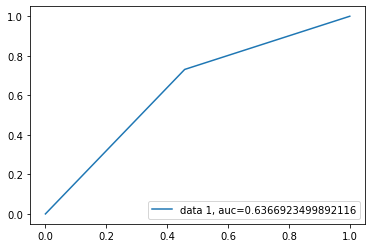

<Figure size 720x720 with 0 Axes>

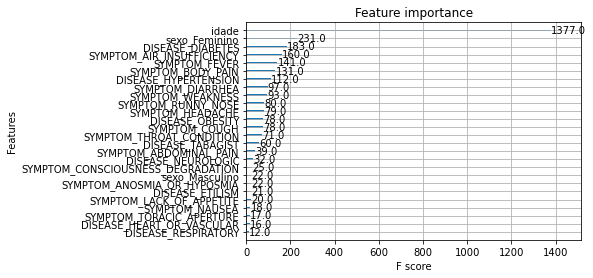

Início do período:  2021-07-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.883788981454882
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.5980066445182725
########################################
"""Métricas f1_score:"""
f1:  0.5020576131687242
Macro:  0.5825051297041393
Micro:  0.5980066445182725
weighted:  0.6201898467522905
########################################
"""Métricas precision_score:"""
Precision:  0.37423312883435583
Macro:  0.618275984707033
Micro:  0.5980066445182725
weighted:  0.7325950633716426


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


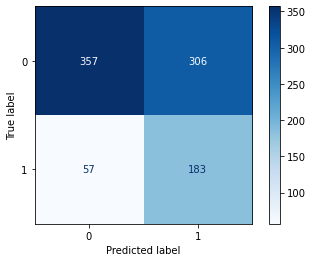

              precision    recall  f1-score   support

           0       0.86      0.54      0.66       663
           1       0.37      0.76      0.50       240

    accuracy                           0.60       903
   macro avg       0.62      0.65      0.58       903
weighted avg       0.73      0.60      0.62       903

roc_auc_score:  0.6504807692307693


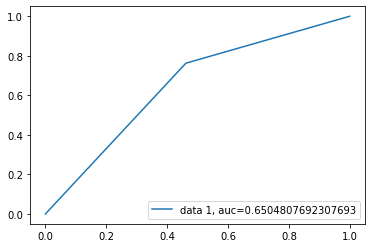

<Figure size 720x720 with 0 Axes>

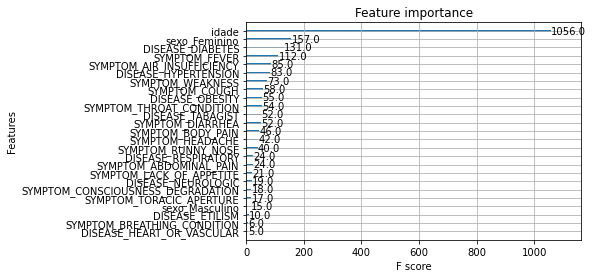

Início do período:  2021-08-19 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.907916259765625
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6210526315789474
########################################
"""Métricas f1_score:"""
f1:  0.41463414634146345
Macro:  0.5672392521590586
Micro:  0.6210526315789474
weighted:  0.6491640984400834
########################################
"""Métricas precision_score:"""
Precision:  0.3227848101265823
Macro:  0.5780590717299579
Micro:  0.6210526315789474
weighted:  0.7151010437486119


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


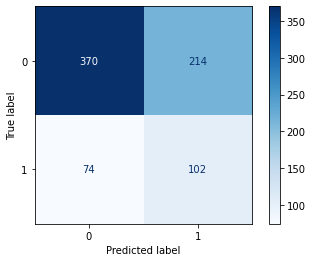

              precision    recall  f1-score   support

           0       0.83      0.63      0.72       584
           1       0.32      0.58      0.41       176

    accuracy                           0.62       760
   macro avg       0.58      0.61      0.57       760
weighted avg       0.72      0.62      0.65       760

roc_auc_score:  0.6065535491905356


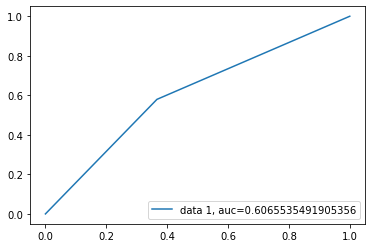

<Figure size 720x720 with 0 Axes>

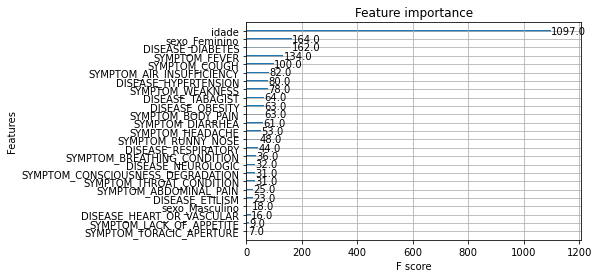

Início do período:  2021-09-18 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.9065662125590569
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.601360544217687
########################################
"""Métricas f1_score:"""
f1:  0.3295194508009153
Macro:  0.5229397834837103
Micro:  0.601360544217687
weighted:  0.6326762171282349
########################################
"""Métricas precision_score:"""
Precision:  0.2589928057553957
Macro:  0.5343104072540654
Micro:  0.601360544217687
weighted:  0.6905110056553515


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


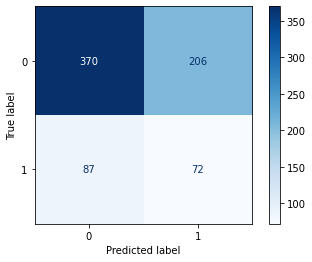

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       576
           1       0.26      0.45      0.33       159

    accuracy                           0.60       735
   macro avg       0.53      0.55      0.52       735
weighted avg       0.69      0.60      0.63       735

roc_auc_score:  0.5475956498951782


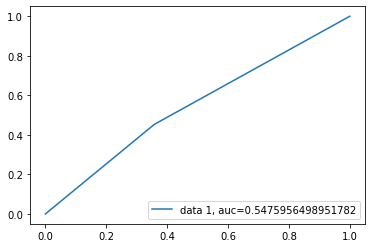

<Figure size 720x720 with 0 Axes>

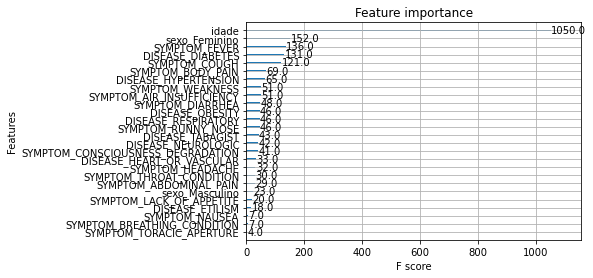

Início do período:  2021-10-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.9497396982310093
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6259087904824852
########################################
"""Métricas f1_score:"""
f1:  0.347926267281106
Macro:  0.5428231892475965
Micro:  0.6259087904824852
weighted:  0.6470344317267049
########################################
"""Métricas precision_score:"""
Precision:  0.2926356589147287
Macro:  0.5455154222356994
Micro:  0.6259087904824852
weighted:  0.6807300478316447


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


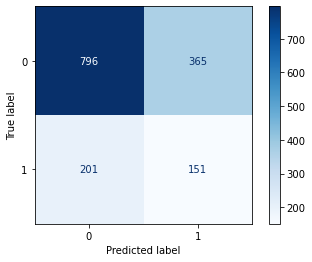

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1161
           1       0.29      0.43      0.35       352

    accuracy                           0.63      1513
   macro avg       0.55      0.56      0.54      1513
weighted avg       0.68      0.63      0.65      1513

roc_auc_score:  0.5572965605669093


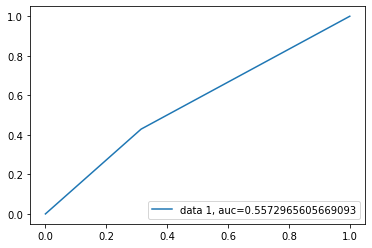

<Figure size 720x720 with 0 Axes>

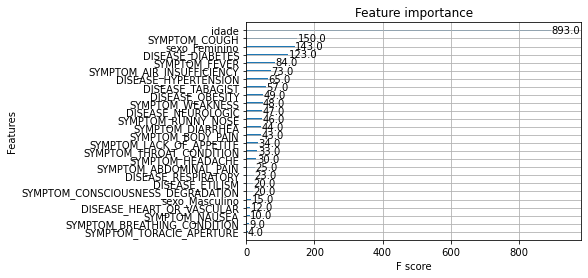

Início do período:  2021-11-17 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.8984057042140682
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5723756906077349
########################################
"""Métricas f1_score:"""
f1:  0.3895899053627761
Macro:  0.5302541363548574
Micro:  0.5723756906077349
weighted:  0.6017519775221032
########################################
"""Métricas precision_score:"""
Precision:  0.3001215066828676
Macro:  0.5497568019736526
Micro:  0.5723756906077349
weighted:  0.6766432504087478


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


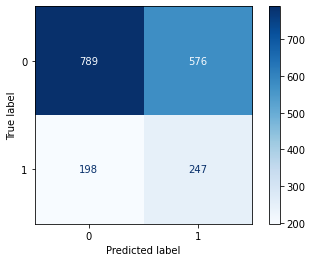

              precision    recall  f1-score   support

           0       0.80      0.58      0.67      1365
           1       0.30      0.56      0.39       445

    accuracy                           0.57      1810
   macro avg       0.55      0.57      0.53      1810
weighted avg       0.68      0.57      0.60      1810

roc_auc_score:  0.5665390788986294


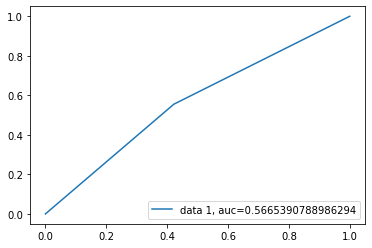

<Figure size 720x720 with 0 Axes>

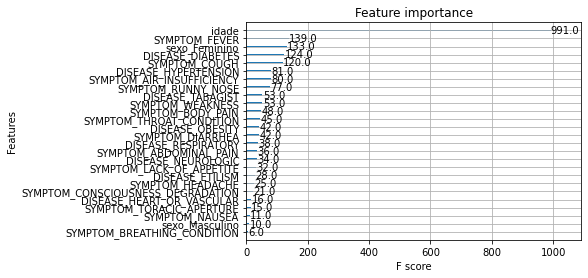

Início do período:  2021-12-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8721335713144015
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5092936802973977
########################################
"""Métricas f1_score:"""
f1:  0.415929203539823
Macro:  0.49642614023145
Micro:  0.5092936802973977
weighted:  0.5285949903963195
########################################
"""Métricas precision_score:"""
Precision:  0.32358003442340794
Macro:  0.5254263808480676
Micro:  0.5092936802973977
weighted:  0.6060898836014167


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


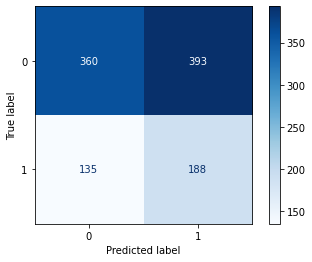

              precision    recall  f1-score   support

           0       0.73      0.48      0.58       753
           1       0.32      0.58      0.42       323

    accuracy                           0.51      1076
   macro avg       0.53      0.53      0.50      1076
weighted avg       0.61      0.51      0.53      1076

roc_auc_score:  0.5300654965278206


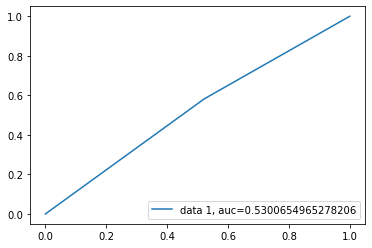

<Figure size 720x720 with 0 Axes>

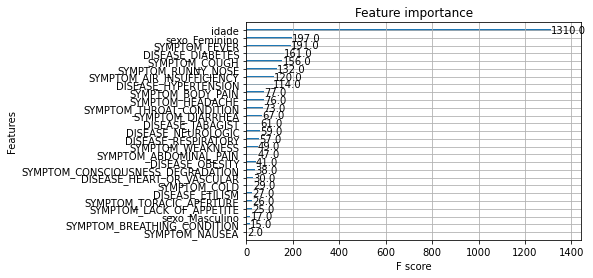

Início do período:  2022-01-16 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8701329307984838
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6415094339622641
########################################
"""Métricas f1_score:"""
f1:  0.5739910313901346
Macro:  0.6322723886592367
Micro:  0.6415094339622641
weighted:  0.6467144356806368
########################################
"""Métricas precision_score:"""
Precision:  0.518918918918919
Macro:  0.633577106518283
Micro:  0.6415094339622641
weighted:  0.6619892611812701


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


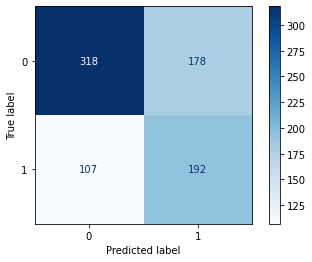

              precision    recall  f1-score   support

           0       0.75      0.64      0.69       496
           1       0.52      0.64      0.57       299

    accuracy                           0.64       795
   macro avg       0.63      0.64      0.63       795
weighted avg       0.66      0.64      0.65       795

roc_auc_score:  0.6416347502427446


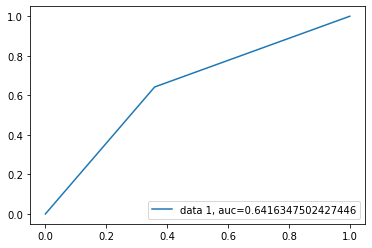

<Figure size 720x720 with 0 Axes>

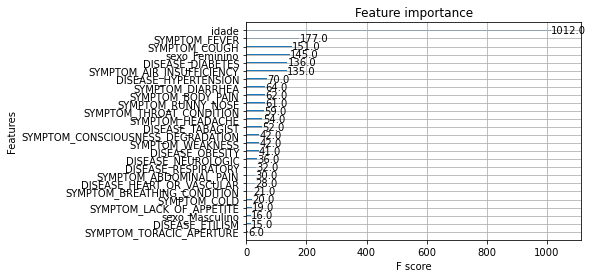

Início do período:  2022-02-15 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8219011526156255
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6719883889695211
########################################
"""Métricas f1_score:"""
f1:  0.5751879699248121
Macro:  0.6540242450096874
Micro:  0.6719883889695211
weighted:  0.6852612596659587
########################################
"""Métricas precision_score:"""
Precision:  0.4722222222222222
Macro:  0.6607686453576864
Micro:  0.6719883889695211
weighted:  0.7354757186755119


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


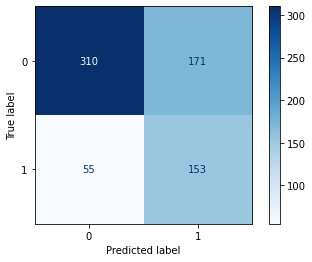

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       481
           1       0.47      0.74      0.58       208

    accuracy                           0.67       689
   macro avg       0.66      0.69      0.65       689
weighted avg       0.74      0.67      0.69       689

roc_auc_score:  0.6900337837837838


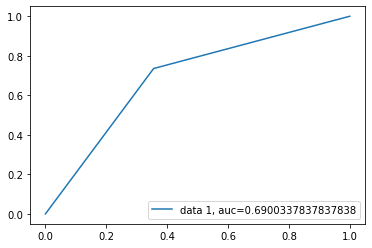

<Figure size 720x720 with 0 Axes>

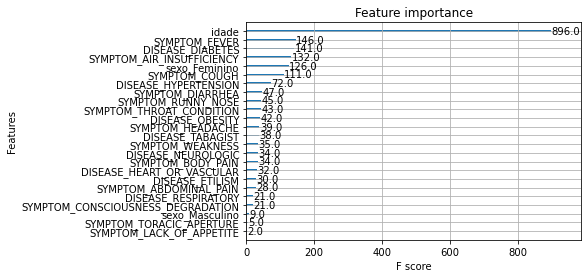

Início do período:  2022-03-17 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8526915315363688
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.7187993680884676
########################################
"""Métricas f1_score:"""
f1:  0.35036496350364965
Macro:  0.5854647398163408
Micro:  0.7187993680884676
weighted:  0.7730245929567975
########################################
"""Métricas precision_score:"""
Precision:  0.22857142857142856
Macro:  0.5953731847348869
Micro:  0.7187993680884676
weighted:  0.8880033377562871


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


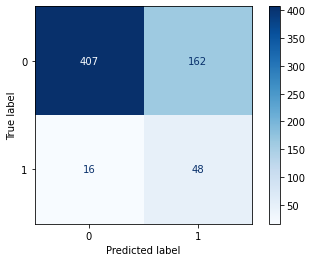

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       569
           1       0.23      0.75      0.35        64

    accuracy                           0.72       633
   macro avg       0.60      0.73      0.59       633
weighted avg       0.89      0.72      0.77       633

roc_auc_score:  0.7326449912126538


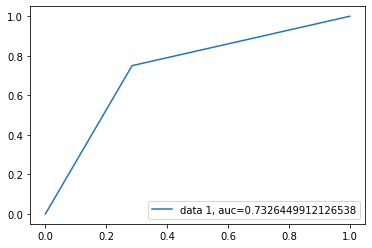

<Figure size 720x720 with 0 Axes>

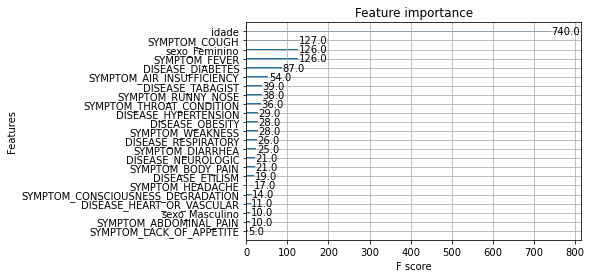

Início do período:  2022-04-16 00:00:00
Final do período:  2022-07-15 00:00:00
########################################

best_score: 0.9414365137338111
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.7389162561576355
########################################
"""Métricas f1_score:"""
f1:  0.20895522388059704
Macro:  0.5263065204948708
Micro:  0.7389162561576355
weighted:  0.7998852244726932
########################################
"""Métricas precision_score:"""
Precision:  0.1320754716981132
Macro:  0.5427044025157233
Micro:  0.7389162561576355
weighted:  0.8966948601171113


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


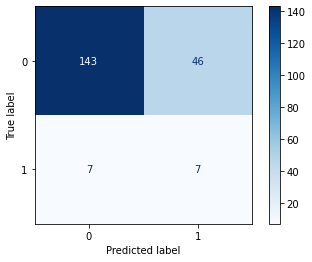

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       189
           1       0.13      0.50      0.21        14

    accuracy                           0.74       203
   macro avg       0.54      0.63      0.53       203
weighted avg       0.90      0.74      0.80       203

roc_auc_score:  0.6283068783068783


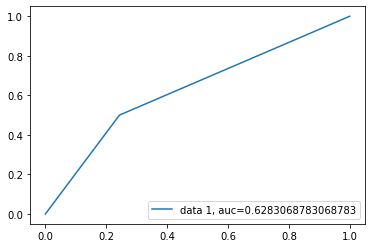

<Figure size 720x720 with 0 Axes>

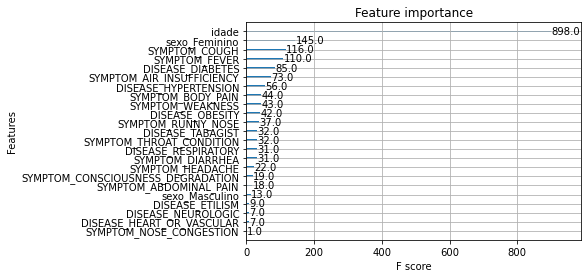

Início do período:  2022-05-16 00:00:00
Final do período:  2022-08-14 00:00:00
########################################

best_score: 0.9874433106575964
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [9]:
apply_periodos(90, df)

Início do período:  2020-02-26 00:00:00
Final do período:  2020-06-25 00:00:00
########################################

best_score: 0.959340843143656
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6661252030488567
########################################
"""Métricas f1_score:"""
f1:  0.5693101225016118
Macro:  0.6483563467027544
Micro:  0.6661252030488567
weighted:  0.68558303906988
########################################
"""Métricas precision_score:"""
Precision:  0.43210178615121114
Macro:  0.6712347541583431
Micro:  0.6661252030488567
weighted:  0.7838540414779583


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


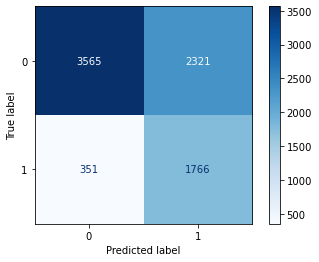

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      5886
           1       0.43      0.83      0.57      2117

    accuracy                           0.67      8003
   macro avg       0.67      0.72      0.65      8003
weighted avg       0.78      0.67      0.69      8003

roc_auc_score:  0.7199369102540459


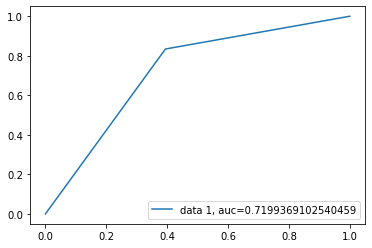

<Figure size 1008x1008 with 0 Axes>

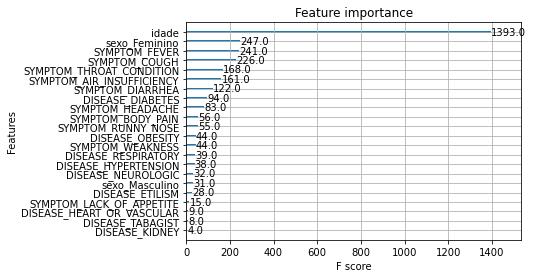

Início do período:  2020-03-27 00:00:00
Final do período:  2020-07-25 00:00:00
########################################

best_score: 0.9105351659976154
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.5707582119041739
########################################
"""Métricas f1_score:"""
f1:  0.49329446064139937
Macro:  0.5604861334912223
Micro:  0.5707582119041739
weighted:  0.5959488662351276
########################################
"""Métricas precision_score:"""
Precision:  0.3419563459983832
Macro:  0.6360575380785567
Micro:  0.5707582119041739
weighted:  0.7912796293295645


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


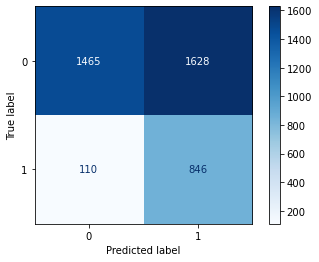

              precision    recall  f1-score   support

           0       0.93      0.47      0.63      3093
           1       0.34      0.88      0.49       956

    accuracy                           0.57      4049
   macro avg       0.64      0.68      0.56      4049
weighted avg       0.79      0.57      0.60      4049

roc_auc_score:  0.6792937081573048


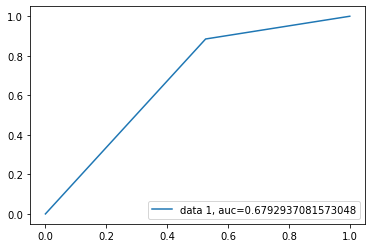

<Figure size 1008x1008 with 0 Axes>

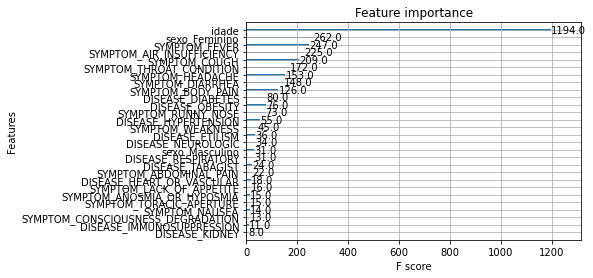

Início do período:  2020-04-26 00:00:00
Final do período:  2020-08-24 00:00:00
########################################

best_score: 0.8534591955693409
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5704675412041709
########################################
"""Métricas f1_score:"""
f1:  0.43818741750989887
Macro:  0.5452576074753415
Micro:  0.5704675412041709
weighted:  0.610839449361339
########################################
"""Métricas precision_score:"""
Precision:  0.29345904537418976
Macro:  0.6161652593642108
Micro:  0.5704675412041709
weighted:  0.81382688589493


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


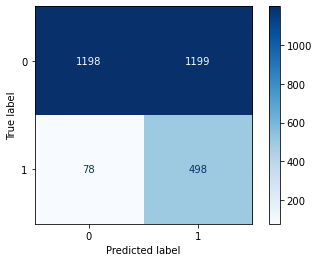

              precision    recall  f1-score   support

           0       0.94      0.50      0.65      2397
           1       0.29      0.86      0.44       576

    accuracy                           0.57      2973
   macro avg       0.62      0.68      0.55      2973
weighted avg       0.81      0.57      0.61      2973

roc_auc_score:  0.6821873696287026


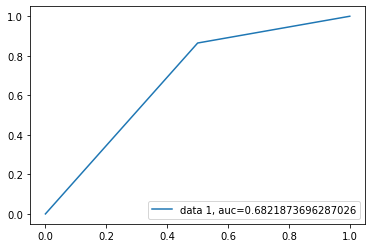

<Figure size 1008x1008 with 0 Axes>

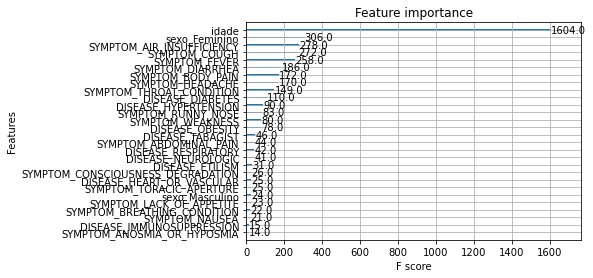

Início do período:  2020-05-26 00:00:00
Final do período:  2020-09-23 00:00:00
########################################

best_score: 0.8620231261586413
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6511734928670041
########################################
"""Métricas f1_score:"""
f1:  0.46769662921348315
Macro:  0.6041426335663582
Micro:  0.6511734928670041
weighted:  0.6887228304661847
########################################
"""Métricas precision_score:"""
Precision:  0.3293768545994065
Macro:  0.6302650193823195
Micro:  0.6511734928670041
weighted:  0.8167796802026525


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


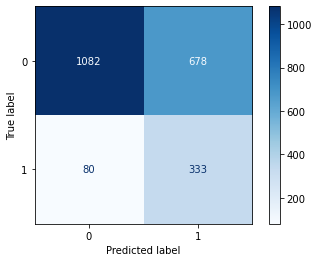

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1760
           1       0.33      0.81      0.47       413

    accuracy                           0.65      2173
   macro avg       0.63      0.71      0.60      2173
weighted avg       0.82      0.65      0.69      2173

roc_auc_score:  0.7105340633942329


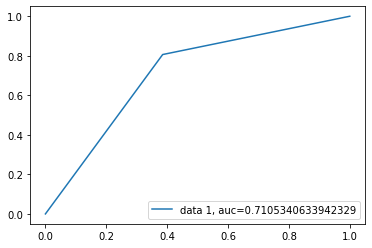

<Figure size 1008x1008 with 0 Axes>

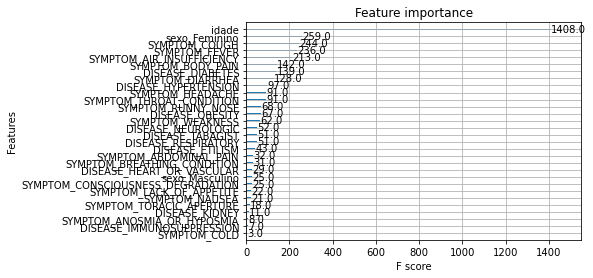

Início do período:  2020-06-25 00:00:00
Final do período:  2020-10-23 00:00:00
########################################

best_score: 0.9250801812884358
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6112565445026178
########################################
"""Métricas f1_score:"""
f1:  0.43856332703213613
Macro:  0.5706330148674195
Micro:  0.6112565445026178
weighted:  0.6442739664614386
########################################
"""Métricas precision_score:"""
Precision:  0.32222222222222224
Macro:  0.5955170517051706
Micro:  0.6112565445026178
weighted:  0.7479039592440919


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


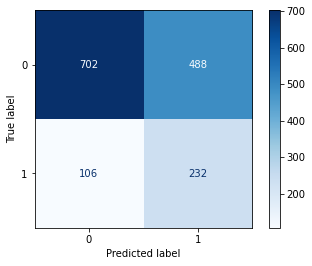

              precision    recall  f1-score   support

           0       0.87      0.59      0.70      1190
           1       0.32      0.69      0.44       338

    accuracy                           0.61      1528
   macro avg       0.60      0.64      0.57      1528
weighted avg       0.75      0.61      0.64      1528

roc_auc_score:  0.6381532494654667


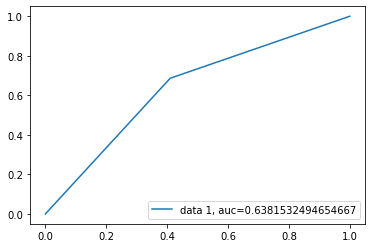

<Figure size 1008x1008 with 0 Axes>

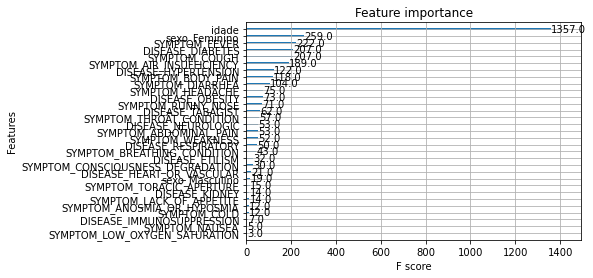

Início do período:  2020-07-25 00:00:00
Final do período:  2020-11-22 00:00:00
########################################

best_score: 0.9328948217975206
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.6570247933884298
########################################
"""Métricas f1_score:"""
f1:  0.4668094218415418
Macro:  0.6070087718344765
Micro:  0.6570247933884298
weighted:  0.6691908526853374
########################################
"""Métricas precision_score:"""
Precision:  0.41132075471698115
Macro:  0.6047926983997054
Micro:  0.6570247933884298
weighted:  0.690602568738324


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


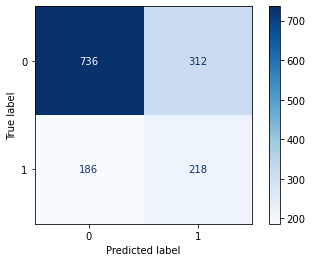

              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1048
           1       0.41      0.54      0.47       404

    accuracy                           0.66      1452
   macro avg       0.60      0.62      0.61      1452
weighted avg       0.69      0.66      0.67      1452

roc_auc_score:  0.6209470183659589


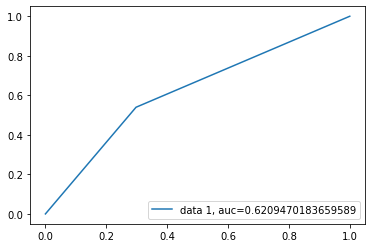

<Figure size 1008x1008 with 0 Axes>

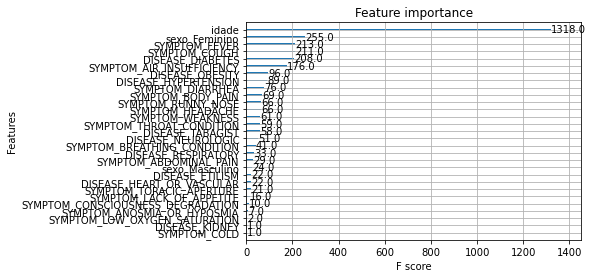

Início do período:  2020-08-24 00:00:00
Final do período:  2020-12-22 00:00:00
########################################

best_score: 0.9107425323070405
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6439610761305095
########################################
"""Métricas f1_score:"""
f1:  0.4842454394693201
Macro:  0.6061961463080865
Micro:  0.6439610761305095
weighted:  0.6491267042393065
########################################
"""Métricas precision_score:"""
Precision:  0.45625
Macro:  0.6043670957542908
Micro:  0.6439610761305095
weighted:  0.656509061346099


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


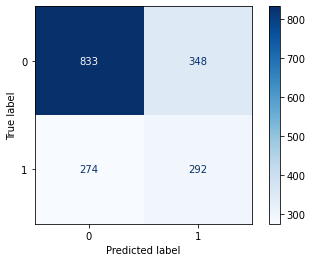

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1181
           1       0.46      0.52      0.48       566

    accuracy                           0.64      1747
   macro avg       0.60      0.61      0.61      1747
weighted avg       0.66      0.64      0.65      1747

roc_auc_score:  0.6106177611953696


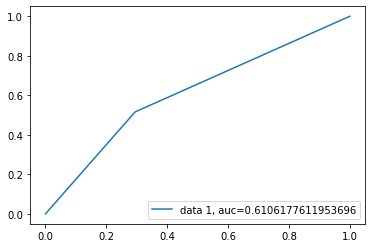

<Figure size 1008x1008 with 0 Axes>

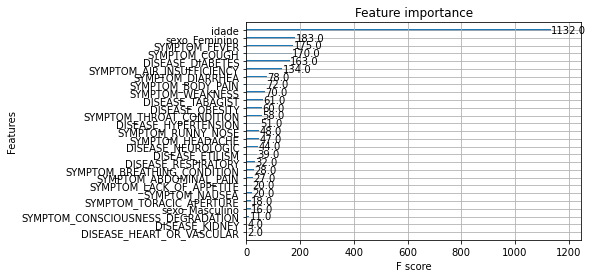

Início do período:  2020-09-23 00:00:00
Final do período:  2021-01-21 00:00:00
########################################

best_score: 0.889996408770845
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6333508679642293
########################################
"""Métricas f1_score:"""
f1:  0.555201021059349
Macro:  0.6216720988965649
Micro:  0.6333508679642293
weighted:  0.642267293450021
########################################
"""Métricas precision_score:"""
Precision:  0.4774972557628979
Macro:  0.6271324662652873
Micro:  0.6333508679642293
weighted:  0.6734949801979057


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


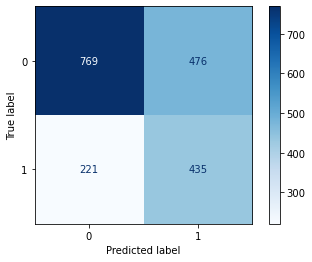

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      1245
           1       0.48      0.66      0.56       656

    accuracy                           0.63      1901
   macro avg       0.63      0.64      0.62      1901
weighted avg       0.67      0.63      0.64      1901

roc_auc_score:  0.6403902194142423


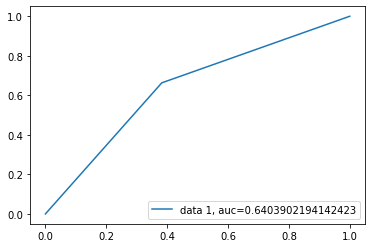

<Figure size 1008x1008 with 0 Axes>

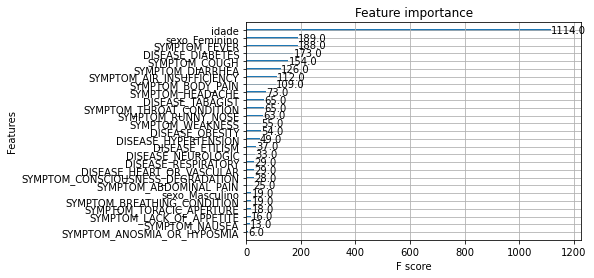

Início do período:  2020-10-23 00:00:00
Final do período:  2021-02-20 00:00:00
########################################

best_score: 0.8861747982113874
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6297850026219193
########################################
"""Métricas f1_score:"""
f1:  0.5705596107055961
Macro:  0.6226069942928902
Micro:  0.6297850026219193
weighted:  0.6398833413357623
########################################
"""Métricas precision_score:"""
Precision:  0.4657398212512413
Macro:  0.6395365772922873
Micro:  0.6297850026219193
weighted:  0.6972257994076425


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


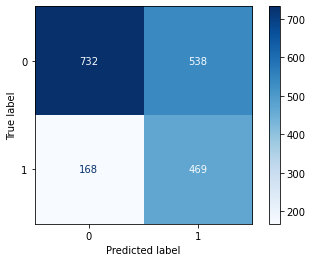

              precision    recall  f1-score   support

           0       0.81      0.58      0.67      1270
           1       0.47      0.74      0.57       637

    accuracy                           0.63      1907
   macro avg       0.64      0.66      0.62      1907
weighted avg       0.70      0.63      0.64      1907

roc_auc_score:  0.656320844509821


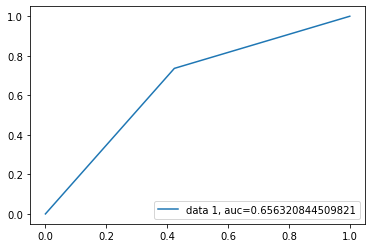

<Figure size 1008x1008 with 0 Axes>

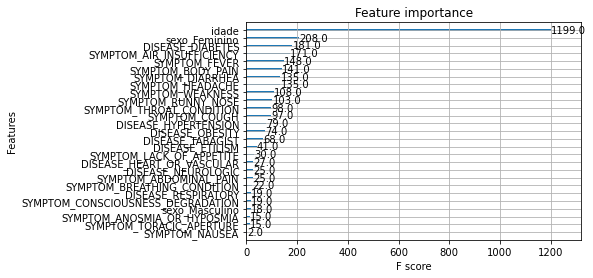

Início do período:  2020-11-22 00:00:00
Final do período:  2021-03-22 00:00:00
########################################

best_score: 0.8557636167158595
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6611374407582938
########################################
"""Métricas f1_score:"""
f1:  0.5822784810126581
Macro:  0.6486143235628075
Micro:  0.6611374407582938
weighted:  0.6718266286573701
########################################
"""Métricas precision_score:"""
Precision:  0.48578391551584077
Macro:  0.6564200130999649
Micro:  0.6611374407582938
weighted:  0.7161291688896703


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


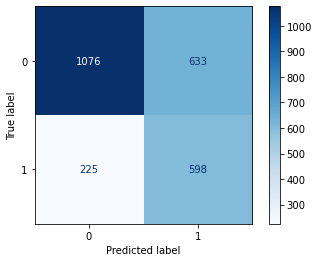

              precision    recall  f1-score   support

           0       0.83      0.63      0.71      1709
           1       0.49      0.73      0.58       823

    accuracy                           0.66      2532
   macro avg       0.66      0.68      0.65      2532
weighted avg       0.72      0.66      0.67      2532

roc_auc_score:  0.6781089607090472


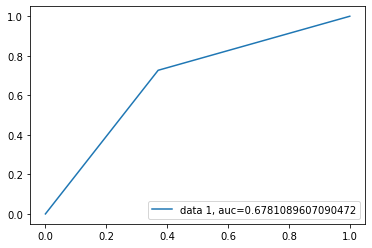

<Figure size 1008x1008 with 0 Axes>

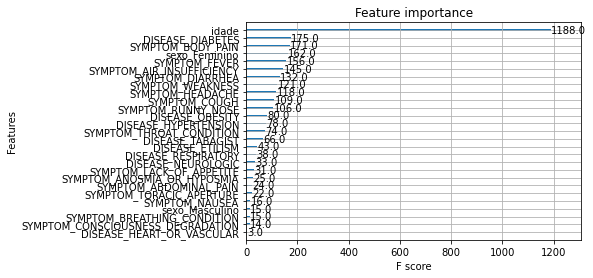

Início do período:  2020-12-22 00:00:00
Final do período:  2021-04-21 00:00:00
########################################

best_score: 0.8494977989955979
best_params_: {'colsample_bytree': 0.5, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6354693648116919
########################################
"""Métricas f1_score:"""
f1:  0.5698175787728027
Macro:  0.6267766264993007
Micro:  0.6354693648116919
weighted:  0.6463072724313769
########################################
"""Métricas precision_score:"""
Precision:  0.46533044420368364
Macro:  0.6421278389242717
Micro:  0.6354693648116919
weighted:  0.7027497674119383


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


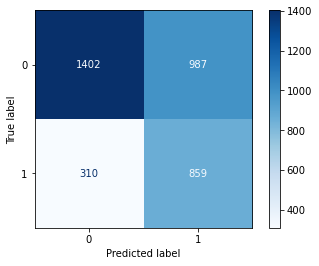

              precision    recall  f1-score   support

           0       0.82      0.59      0.68      2389
           1       0.47      0.73      0.57      1169

    accuracy                           0.64      3558
   macro avg       0.64      0.66      0.63      3558
weighted avg       0.70      0.64      0.65      3558

roc_auc_score:  0.6608362537020082


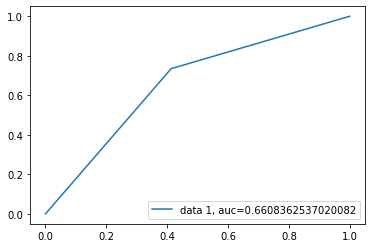

<Figure size 1008x1008 with 0 Axes>

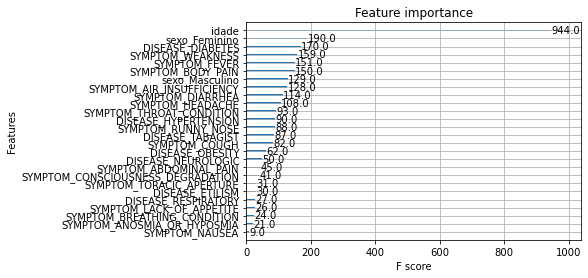

Início do período:  2021-01-21 00:00:00
Final do período:  2021-05-21 00:00:00
########################################

best_score: 0.8535471926545111
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.62113532691333
########################################
"""Métricas f1_score:"""
f1:  0.5487473588892242
Macro:  0.611128429390015
Micro:  0.62113532691333
weighted:  0.633197353469869
########################################
"""Métricas precision_score:"""
Precision:  0.44602551521099115
Macro:  0.627100807919961
Micro:  0.62113532691333
weighted:  0.6911608962680912


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


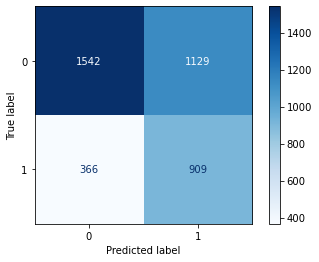

              precision    recall  f1-score   support

           0       0.81      0.58      0.67      2671
           1       0.45      0.71      0.55      1275

    accuracy                           0.62      3946
   macro avg       0.63      0.65      0.61      3946
weighted avg       0.69      0.62      0.63      3946

roc_auc_score:  0.6451265223423701


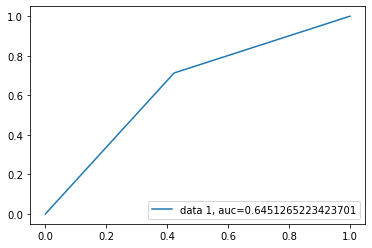

<Figure size 1008x1008 with 0 Axes>

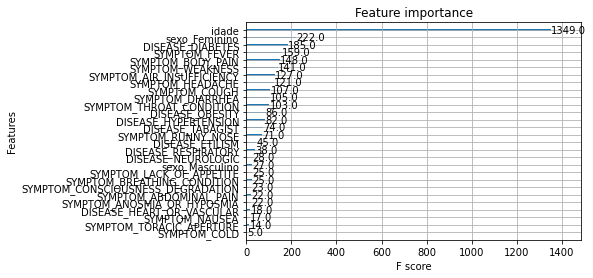

Início do período:  2021-02-20 00:00:00
Final do período:  2021-06-20 00:00:00
########################################

best_score: 0.8564366185841765
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5658765159867696
########################################
"""Métricas f1_score:"""
f1:  0.5268849504355663
Macro:  0.5629077158594944
Micro:  0.5658765159867696
weighted:  0.5769276014103727
########################################
"""Métricas precision_score:"""
Precision:  0.39486717694732104
Macro:  0.6153440362348546
Micro:  0.5658765159867696
weighted:  0.7011525603015573


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


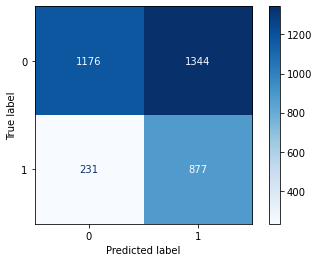

              precision    recall  f1-score   support

           0       0.84      0.47      0.60      2520
           1       0.39      0.79      0.53      1108

    accuracy                           0.57      3628
   macro avg       0.62      0.63      0.56      3628
weighted avg       0.70      0.57      0.58      3628

roc_auc_score:  0.6290914560770157


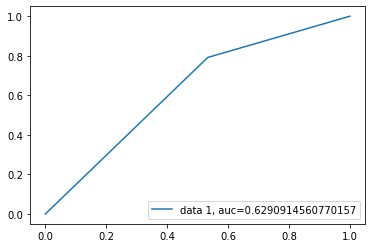

<Figure size 1008x1008 with 0 Axes>

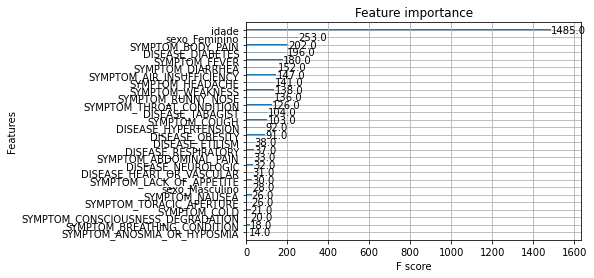

Início do período:  2021-03-22 00:00:00
Final do período:  2021-07-20 00:00:00
########################################

best_score: 0.8452234061618084
best_params_: {'colsample_bytree': 0.9, 'gamma': 1, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5579487179487179
########################################
"""Métricas f1_score:"""
f1:  0.516996638027643
Macro:  0.5547479250648772
Micro:  0.5579487179487179
weighted:  0.5705841059861377
########################################
"""Métricas precision_score:"""
Precision:  0.3785557986870897
Macro:  0.6177191026252221
Micro:  0.5579487179487179
weighted:  0.7180450424310643


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


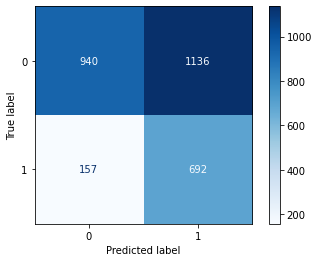

              precision    recall  f1-score   support

           0       0.86      0.45      0.59      2076
           1       0.38      0.82      0.52       849

    accuracy                           0.56      2925
   macro avg       0.62      0.63      0.55      2925
weighted avg       0.72      0.56      0.57      2925

roc_auc_score:  0.633935197478162


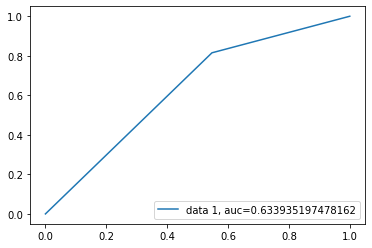

<Figure size 1008x1008 with 0 Axes>

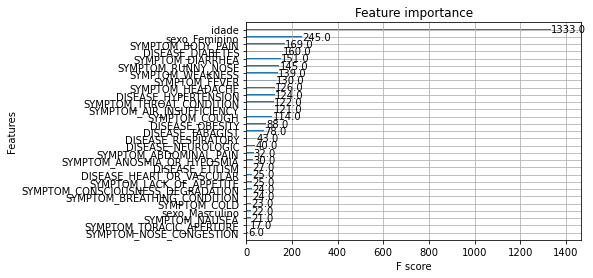

Início do período:  2021-04-21 00:00:00
Final do período:  2021-08-19 00:00:00
########################################

best_score: 0.872590702947846
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5975405254332029
########################################
"""Métricas f1_score:"""
f1:  0.5516811955168119
Macro:  0.5932848168253431
Micro:  0.5975405254332029
weighted:  0.6085635083847087
########################################
"""Métricas precision_score:"""
Precision:  0.42596153846153845
Macro:  0.6308712899250283
Micro:  0.5975405254332029
weighted:  0.7061232221282217


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


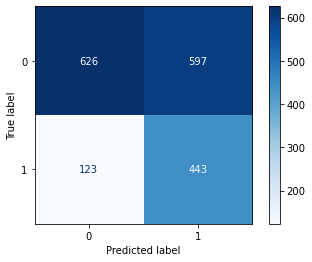

              precision    recall  f1-score   support

           0       0.84      0.51      0.63      1223
           1       0.43      0.78      0.55       566

    accuracy                           0.60      1789
   macro avg       0.63      0.65      0.59      1789
weighted avg       0.71      0.60      0.61      1789

roc_auc_score:  0.647270801972789


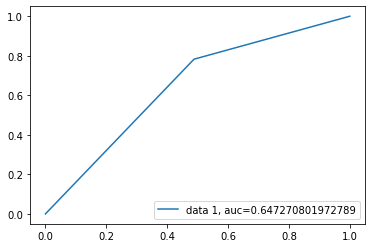

<Figure size 1008x1008 with 0 Axes>

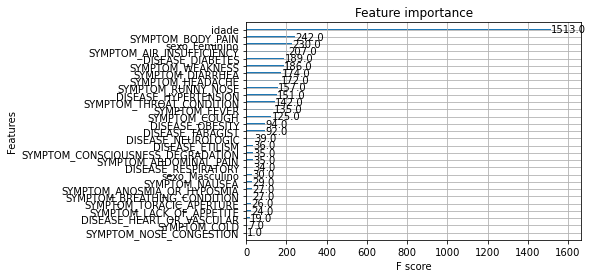

Início do período:  2021-05-21 00:00:00
Final do período:  2021-09-18 00:00:00
########################################

best_score: 0.8766058306441706
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.581081081081081
########################################
"""Métricas f1_score:"""
f1:  0.5547576301615799
Macro:  0.5796116699452237
Micro:  0.581081081081081
weighted:  0.5882602040591268
########################################
"""Métricas precision_score:"""
Precision:  0.42445054945054944
Macro:  0.6277954501638712
Micro:  0.581081081081081
weighted:  0.6985539798039798


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


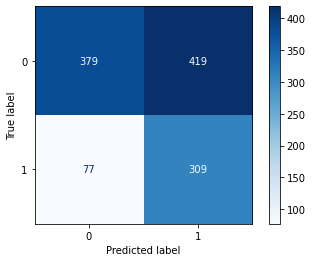

              precision    recall  f1-score   support

           0       0.83      0.47      0.60       798
           1       0.42      0.80      0.55       386

    accuracy                           0.58      1184
   macro avg       0.63      0.64      0.58      1184
weighted avg       0.70      0.58      0.59      1184

roc_auc_score:  0.6377277390367109


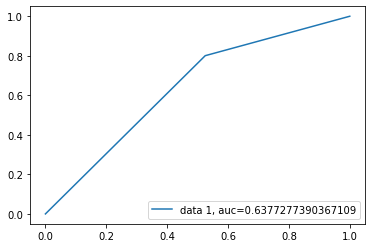

<Figure size 1008x1008 with 0 Axes>

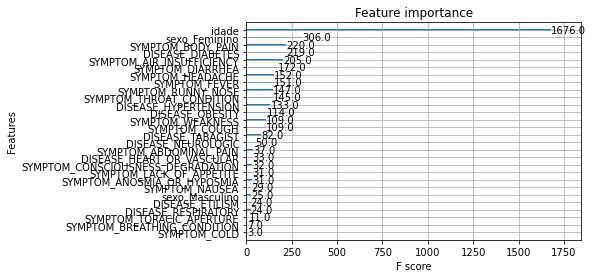

Início do período:  2021-06-20 00:00:00
Final do período:  2021-10-18 00:00:00
########################################

best_score: 0.8800819535576023
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5758354755784062
########################################
"""Métricas f1_score:"""
f1:  0.5054945054945055
Macro:  0.5670758348927891
Micro:  0.5758354755784062
weighted:  0.5945684421048764
########################################
"""Métricas precision_score:"""
Precision:  0.37315634218289084
Macro:  0.615003528964656
Micro:  0.5758354755784062
weighted:  0.7229747237489745


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


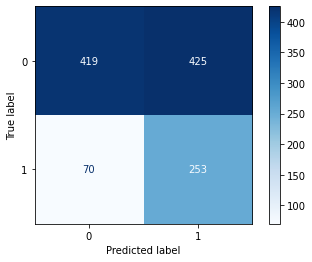

              precision    recall  f1-score   support

           0       0.86      0.50      0.63       844
           1       0.37      0.78      0.51       323

    accuracy                           0.58      1167
   macro avg       0.62      0.64      0.57      1167
weighted avg       0.72      0.58      0.59      1167

roc_auc_score:  0.6398636156882309


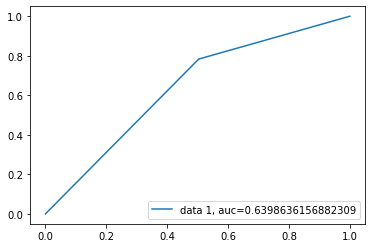

<Figure size 1008x1008 with 0 Axes>

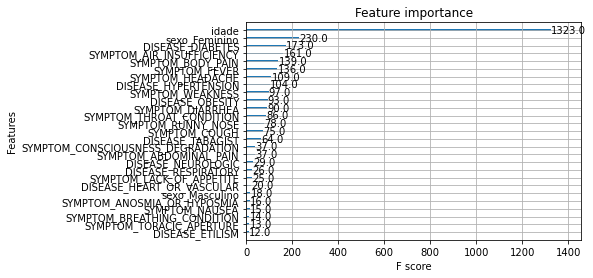

Início do período:  2021-07-20 00:00:00
Final do período:  2021-11-17 00:00:00
########################################

best_score: 0.8638352250393082
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5521698984302862
########################################
"""Métricas f1_score:"""
f1:  0.4340723453908985
Macro:  0.531780252145411
Micro:  0.5521698984302862
weighted:  0.5832956859005604
########################################
"""Métricas precision_score:"""
Precision:  0.30948419301164726
Macro:  0.5821279886220062
Micro:  0.5521698984302862
weighted:  0.7258764718108474


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


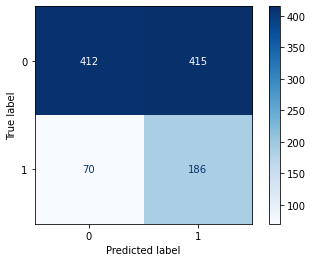

              precision    recall  f1-score   support

           0       0.85      0.50      0.63       827
           1       0.31      0.73      0.43       256

    accuracy                           0.55      1083
   macro avg       0.58      0.61      0.53      1083
weighted avg       0.73      0.55      0.58      1083

roc_auc_score:  0.6123743576178959


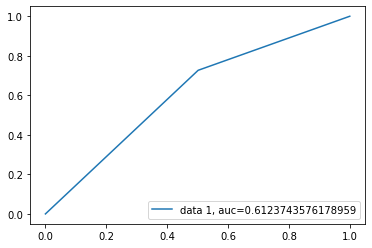

<Figure size 1008x1008 with 0 Axes>

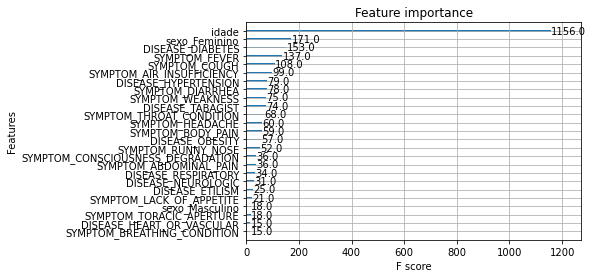

Início do período:  2021-08-19 00:00:00
Final do período:  2021-12-17 00:00:00
########################################

best_score: 0.8952481197303683
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5872382851445663
########################################
"""Métricas f1_score:"""
f1:  0.35109717868338564
Macro:  0.5242327998680086
Micro:  0.5872382851445663
weighted:  0.6245237230068581
########################################
"""Métricas precision_score:"""
Precision:  0.26229508196721313
Macro:  0.5452100409836066
Micro:  0.5872382851445663
weighted:  0.7090919863360737


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


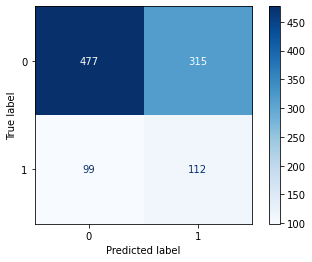

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       792
           1       0.26      0.53      0.35       211

    accuracy                           0.59      1003
   macro avg       0.55      0.57      0.52      1003
weighted avg       0.71      0.59      0.62      1003

roc_auc_score:  0.5665392072382595


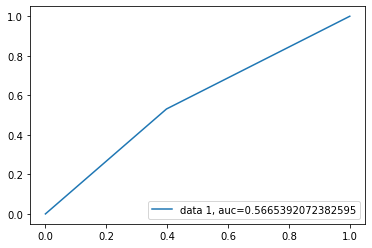

<Figure size 1008x1008 with 0 Axes>

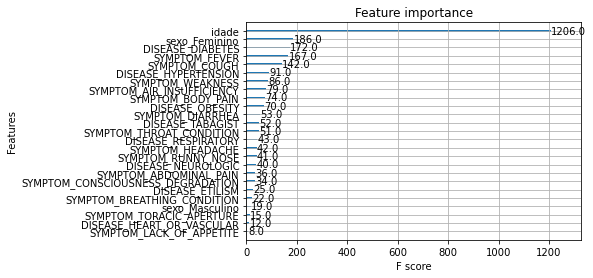

Início do período:  2021-09-18 00:00:00
Final do período:  2022-01-16 00:00:00
########################################

best_score: 0.911437109318818
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5850945494994438
########################################
"""Métricas f1_score:"""
f1:  0.3180987202925046
Macro:  0.5099686247345816
Micro:  0.5850945494994438
weighted:  0.6154010305125416
########################################
"""Métricas precision_score:"""
Precision:  0.2525399129172714
Macro:  0.5221220754847854
Micro:  0.5850945494994438
weighted:  0.6702573238811723


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


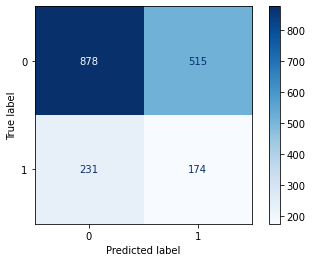

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1393
           1       0.25      0.43      0.32       405

    accuracy                           0.59      1798
   macro avg       0.52      0.53      0.51      1798
weighted avg       0.67      0.59      0.62      1798

roc_auc_score:  0.5299619792082103


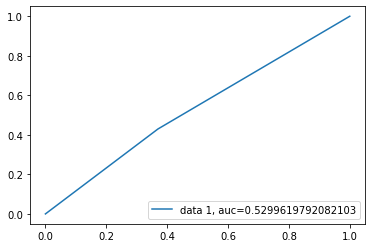

<Figure size 1008x1008 with 0 Axes>

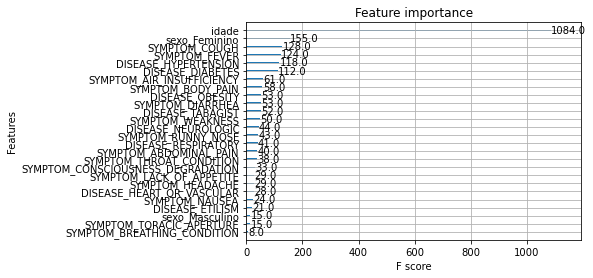

Início do período:  2021-10-18 00:00:00
Final do período:  2022-02-15 00:00:00
########################################

best_score: 0.9199258000703402
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6147826086956522
########################################
"""Métricas f1_score:"""
f1:  0.38386648122392214
Macro:  0.5518320388409301
Micro:  0.6147826086956522
weighted:  0.6361069316626811
########################################
"""Métricas precision_score:"""
Precision:  0.3190751445086705
Macro:  0.5560532516968439
Micro:  0.6147826086956522
weighted:  0.6749544411295189


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


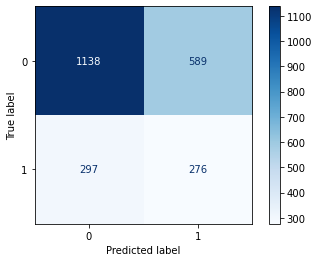

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1727
           1       0.32      0.48      0.38       573

    accuracy                           0.61      2300
   macro avg       0.56      0.57      0.55      2300
weighted avg       0.67      0.61      0.64      2300

roc_auc_score:  0.5703107710310832


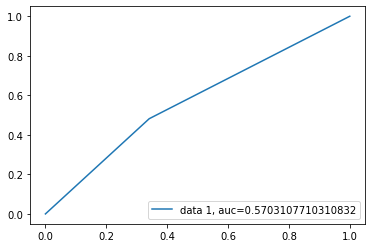

<Figure size 1008x1008 with 0 Axes>

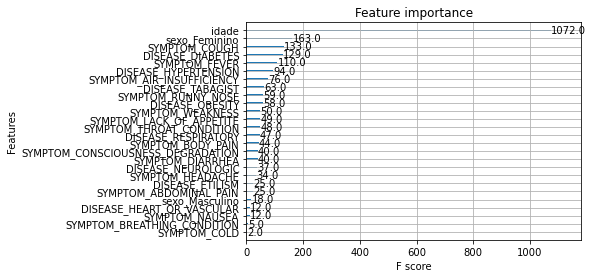

Início do período:  2021-11-17 00:00:00
Final do período:  2022-03-17 00:00:00
########################################

best_score: 0.8843160781815061
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5307545973367153
########################################
"""Métricas f1_score:"""
f1:  0.42277691107644305
Macro:  0.5137388828886489
Micro:  0.5307545973367153
weighted:  0.552327062433586
########################################
"""Métricas precision_score:"""
Precision:  0.3272946859903382
Macro:  0.5414844591500423
Micro:  0.5307545973367153
weighted:  0.6323487319742921


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


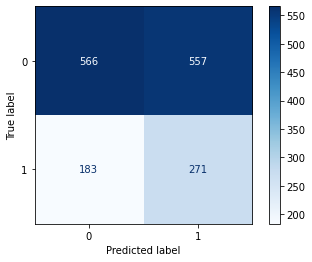

              precision    recall  f1-score   support

           0       0.76      0.50      0.60      1123
           1       0.33      0.60      0.42       454

    accuracy                           0.53      1577
   macro avg       0.54      0.55      0.51      1577
weighted avg       0.63      0.53      0.55      1577

roc_auc_score:  0.5504617116675361


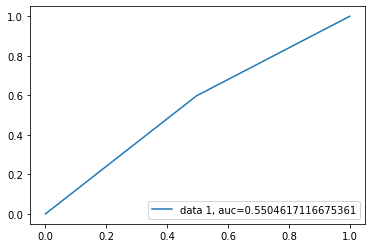

<Figure size 1008x1008 with 0 Axes>

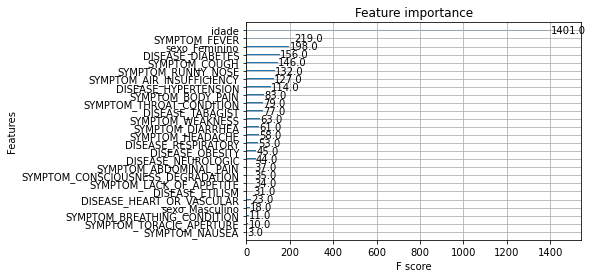

Início do período:  2021-12-17 00:00:00
Final do período:  2022-04-16 00:00:00
########################################

best_score: 0.8500070515131981
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.5600375234521576
########################################
"""Métricas f1_score:"""
f1:  0.518974358974359
Macro:  0.5568078363583981
Micro:  0.5600375234521576
weighted:  0.5676681028495014
########################################
"""Métricas precision_score:"""
Precision:  0.42521008403361343
Macro:  0.5777855091081018
Micro:  0.5600375234521576
weighted:  0.6215829575816416


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


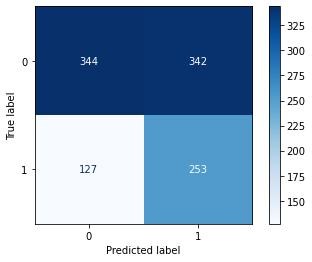

              precision    recall  f1-score   support

           0       0.73      0.50      0.59       686
           1       0.43      0.67      0.52       380

    accuracy                           0.56      1066
   macro avg       0.58      0.58      0.56      1066
weighted avg       0.62      0.56      0.57      1066

roc_auc_score:  0.5836235998158662


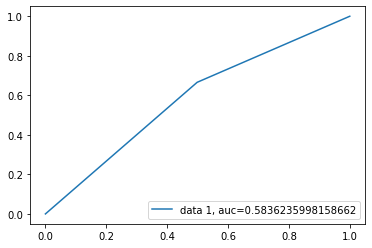

<Figure size 1008x1008 with 0 Axes>

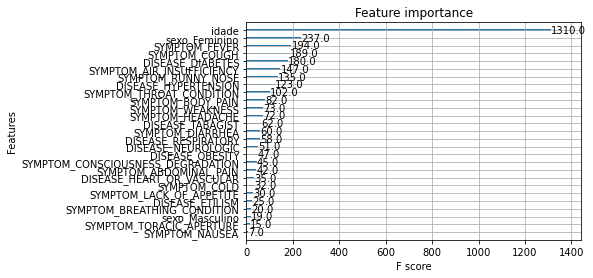

Início do período:  2022-01-16 00:00:00
Final do período:  2022-05-16 00:00:00
########################################

best_score: 0.8567503791887126
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.66008316008316
########################################
"""Métricas f1_score:"""
f1:  0.5714285714285714
Macro:  0.6448874123292727
Micro:  0.66008316008316
weighted:  0.6691700645189018
########################################
"""Métricas precision_score:"""
Precision:  0.4943310657596372
Macro:  0.6473574714594731
Micro:  0.66008316008316
weighted:  0.6979420837386289


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


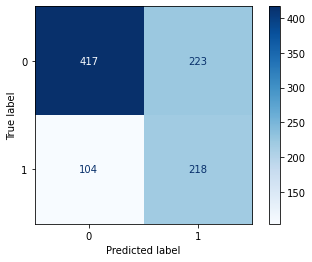

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       640
           1       0.49      0.68      0.57       322

    accuracy                           0.66       962
   macro avg       0.65      0.66      0.64       962
weighted avg       0.70      0.66      0.67       962

roc_auc_score:  0.6642905667701863


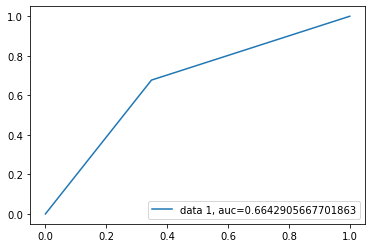

<Figure size 1008x1008 with 0 Axes>

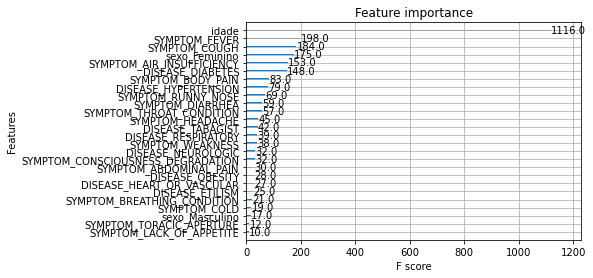

Início do período:  2022-02-15 00:00:00
Final do período:  2022-06-15 00:00:00
########################################

best_score: 0.8355091381795916
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 5}
########################################

accuracy_score: 0.6949152542372882
########################################
"""Métricas f1_score:"""
f1:  0.4642857142857143
Macro:  0.6255077860528098
Micro:  0.6949152542372882
weighted:  0.7309852770733164
########################################
"""Métricas precision_score:"""
Precision:  0.3333333333333333
Macro:  0.6329588014981273
Micro:  0.6949152542372882
weighted:  0.8289849552466196


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


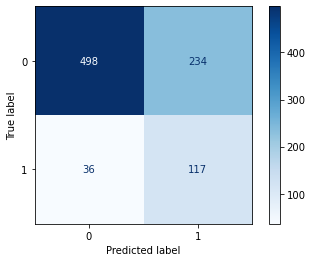

              precision    recall  f1-score   support

           0       0.93      0.68      0.79       732
           1       0.33      0.76      0.46       153

    accuracy                           0.69       885
   macro avg       0.63      0.72      0.63       885
weighted avg       0.83      0.69      0.73       885

roc_auc_score:  0.7225168756027001


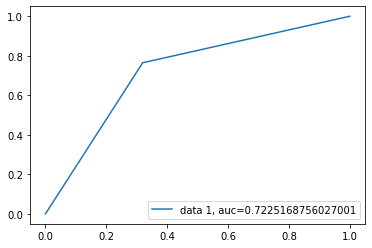

<Figure size 1008x1008 with 0 Axes>

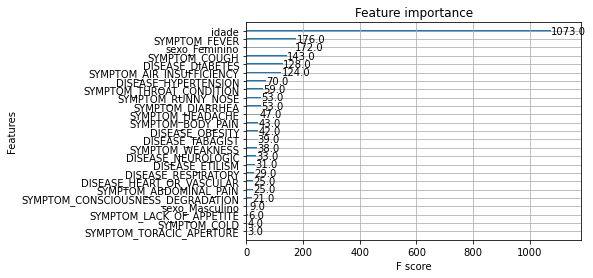

Início do período:  2022-03-17 00:00:00
Final do período:  2022-07-15 00:00:00
########################################

best_score: 0.880645751953125
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################

accuracy_score: 0.7814569536423841
########################################
"""Métricas f1_score:"""
f1:  0.30769230769230765
Macro:  0.5889706623651577
Micro:  0.7814569536423841
weighted:  0.8292680647015661
########################################
"""Métricas precision_score:"""
Precision:  0.2
Macro:  0.5839650145772595
Micro:  0.7814569536423841
weighted:  0.9119881065008786


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


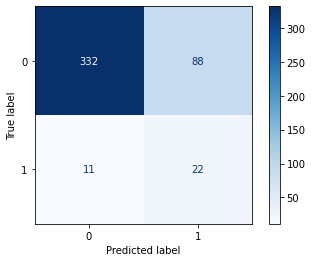

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       420
           1       0.20      0.67      0.31        33

    accuracy                           0.78       453
   macro avg       0.58      0.73      0.59       453
weighted avg       0.91      0.78      0.83       453

roc_auc_score:  0.7285714285714284


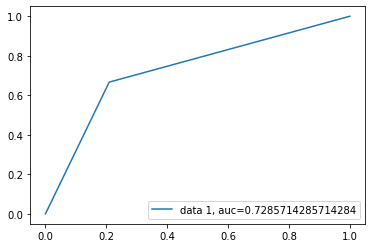

<Figure size 1008x1008 with 0 Axes>

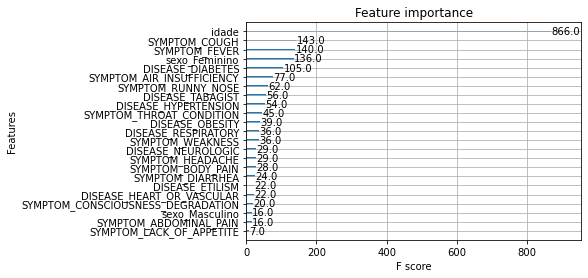

Início do período:  2022-04-16 00:00:00
Final do período:  2022-08-14 00:00:00
########################################

best_score: 0.9575470439630159
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.25, 'max_depth': 7, 'scale_pos_weight': 3}
########################################



ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [11]:
apply_periodos(120, df)